# Calculate the TSN intrinsic value

In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from ipynb.fs.full.c_Stock_visual_QC import read_data_from_sql          # import function from other .ipynb file
pd.options.mode.chained_assignment = None # not to get SettingWithCopyWarning

import warnings
import statsmodels.api as sm

Connection to SQLite DB successful!
Data has been collected!
Datatype has been updated!
Connection closed!


## To Set Vriables please scroll down...

## Function to use

In [2]:
def calculate_missing_columns(df):
    # derived columns
    df['tot_liab'] = df['tot_ass'] - df['tot_equity']
    df['inc_b_tax'] = df['net_inc'] + df['inc_tax_exp']
    df['ebitda'] = df['rev'] - df['cost_sale'] - df['sale_gen_adm']
    df['ebit'] = df['ebitda'] - df['depr_amort']
    df['nopat'] = df['ebit'] - df['inc_tax_exp']
    df['other_curr_ass_lesscash'] = df['acc_rec'] + df['invent'] + df['other_curr_ass']
    df['tot_curr_liab_lessdebt'] = df['tot_curr_liab'] - df['short_debt']
    df['nwc'] = df['other_curr_ass_lesscash'] - df['tot_curr_liab_lessdebt']
    # capex calculation
    capex = []
    for index in range(len(df)):
        if index > 0:
            ppe_change = df['ppe_net'].iloc[index] - df['ppe_net'].iloc[index-1]
            depr_amort = df['depr_amort'].iloc[index]
            capex.append(ppe_change + depr_amort)
        else:
            capex.append(np.nan)
    df.loc[:, 'capex'] = capex

    return df

In [3]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    from statsmodels.tsa.arima.model import ARIMA
    from sklearn.metrics import mean_squared_error
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    print(error)
    return error

In [4]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order, mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return best_cfg

In [5]:
# create a function to calculate ratios
def calculate_is_margins(df):
    is_incomes = ['cost_sale', 'sale_gen_adm']
    calc_margins = dict()
    # plot and calculate ratios
    for income in is_incomes:
        if income != 'inc_tax_exp':
            div = 'rev'
        else:
            div = 'inc_b_tax'

        fig, ax1 = plt.subplots(figsize=(15, 6))

        ax1.plot(df['end'], df[income]/df[div], label=income.replace('_', ' ').upper())
        ax1.axhline(y=(df[income]/df[div]).mean(), color='r', label='Average value')
        
        ax1.set_xlabel('Date')
        ax1.set_ylabel(income.replace('_', ' ').upper())
        
        plt.legend()
        plt.show()

        calc_margins[income+'_margin'] = (df[income]/df[div]).mean()

        print(str(income)+' is divided by the revenue.')
        print('Average value: '+str((df[income]/df[div]).mean()))

    return calc_margins

In [6]:
def predict_cos_sale_gen_adm(input_df, is_ratio_dictionary):
    # predict Cost Of Sales & Sale, General Administration from the Revenue
    for column in ['cost_sale', 'sale_gen_adm']:
        input_df[column] = input_df['rev'] * is_ratio_dictionary[column+'_margin']

    return input_df

In [7]:
def fixed_asset_ratios(df):
    # calculate PPE start & CAPEX
    df['ppe_net_start'] = [df['ppe_net'].values[i-1] if i > 0 else np.nan for i in range(len(df['ppe_net'].values))]
    df['capex'] = df['ppe_net'] - df['ppe_net_start'] + df['depr_amort']
    
    #calculate ratio
    fixed_asset_ratios = dict()
    # D&A ratio
    for column in ['depr_amort', 'capex']:
        ratio = df[column]/df['ppe_net_start']
        ratio.hist()
        plt.show()
        fixed_asset_ratios[column+'_ratio'] = ratio.mean()
        print('Average', column, 'value is', fixed_asset_ratios[column+'_ratio'])
    return fixed_asset_ratios

In [8]:
def predict_fixed_assets(raw_df, prediction_df, fxd_ass_ratios):
    # get the last measured PPE as start in case of prediction
    ppe_start_pred = [raw_df['ppe_net'].iloc[-1]]
    depr_amort_pred = []
    capex_pred = []
    ppe_net = []
    # calculate prediction
    for index in range(len(prediction_df)):
        depr_amort_pred.append(ppe_start_pred[-1] * fxd_ass_ratios['depr_amort_ratio'])
        capex_pred.append(ppe_start_pred[-1] * fxd_ass_ratios['capex_ratio'])
        ppe_net.append(ppe_start_pred[-1] - depr_amort_pred[-1] + capex_pred[-1])
        # add the last PPE as starting to the PPE start
        ppe_start_pred.append(ppe_net[-1])
    
    prediction_df['depr_amort'] = depr_amort_pred
    prediction_df['capex'] = capex_pred
    prediction_df['ppe_net'] = ppe_net

    return prediction_df

In [9]:
def calc_eff_tax_rate(df):
    if df['end'].iloc[-1] > pd.Timestamp('2017-01-01'):
        eff_tax_rate = 0.21
    else:
        eff_tax_rate = (df['inc_tax_exp']/df['ebit']).mean()
        # plot
        (df['inc_tax_exp']/df['ebit']).hist(range=[0, 1])
        plt.show()

    print('Effective tax rate is', eff_tax_rate)
    return eff_tax_rate

In [10]:
def calculate_ebitda_ebit_nopat(prediction_df, eff_tax_rate):
    prediction_df['ebitda'] = prediction_df['rev'] - prediction_df['cost_sale'] - prediction_df['sale_gen_adm']
    prediction_df['ebit'] = prediction_df['ebitda'] - prediction_df['depr_amort']
    prediction_df['nopat'] = prediction_df['ebit'] - (prediction_df['ebit'] * eff_tax_rate)
    return prediction_df

In [11]:
def plot_hist_pred(hist_df, pred_df):
    # reset index
    pred_df.index = [i for i in range(len(hist_df), len(hist_df) + len(pred_df))]
    
    for column in pred_df.columns:
        try:
            fig, ax1 = plt.subplots(figsize=(15, 6))

            ax1.plot(hist_df.index, hist_df[column], color='k', label='Historical data')
            ax1.plot(pred_df.index, pred_df[column], color='r', label='Predicted values')

            ax1.set_xlabel('Index')
            ax1.set_ylabel(column.replace('_', ' ').upper())

            plt.legend()
            plt.show()
        except:
            continue

In [12]:
def calculate_nwc_ratios(df):
    result = dict()
    # Days Sales Outstanding (dso)
    dso = (df['acc_rec'] / df['rev']) * 360
    dso.hist()
    plt.show()
    result['dso'] = dso.mean()
    print('DSO:', result['dso'])

    #Days Inventory Out. (dis)
    dio = (df['invent'] / df['cost_sale']) * 360
    dio.hist()
    plt.show()
    result['dio'] = dio.mean()
    print('DIO:', result['dio'])

    #Days Payable Out. (dpo)
    dpo = (df['acc_pay'] / df['cost_sale']) * 360
    dpo.hist()
    plt.show()
    result['dpo'] = dpo.mean()
    print('DPO:', result['dpo'])


    #Sum of Other current assets per revenue --> soca_rev
    # calculate the non cach non accoint recivable and inventory total current assets ratio to revenue
    soca_rev = (df['tot_curr_ass'] - df['acc_rec'] - df['invent'] - df['cash_cash_eq']) / df['rev']
    soca_rev.hist()
    plt.show()
    result['soca_rev'] = soca_rev.mean()
    print('Sum Other Current Assets:', result['soca_rev'])

    #Sum of Other current liabilities per revenue --> socl_rev
    # calculate the non current debt non account payable total current liabilities ratio to revenue
    socl_rev = (df['tot_curr_liab'] - df['short_debt'] - df['acc_pay']) / df['rev']
    socl_rev.hist()
    plt.show()
    result['socl_rev'] = socl_rev.mean()
    print('Sum Other Current Liabilities per Rec', result['socl_rev'])
    
    return result

In [13]:
def predict_curr_ass_liab(df_prediction, nwc_ratios):
    # calculate assets, liabilities, and net working capital from NWC ratio
    df_prediction['acc_rec'] = (df_prediction['rev'] * nwc_ratios['dso']) / 360
    df_prediction['invent'] = (df_prediction['cost_sale'] * nwc_ratios['dio']) / 360
    df_prediction['acc_pay'] = (df_prediction['cost_sale'] * nwc_ratios['dpo']) / 360
    
    df_prediction['other_curr_ass_lesscash'] = df_prediction['acc_rec'] + df_prediction['invent'] + (df_prediction['rev'] * nwc_ratios['soca_rev'])
    df_prediction['tot_curr_liab_lessdebt'] = df_prediction['acc_pay'] + (df_prediction['rev'] * nwc_ratios['socl_rev'])
    df_prediction['nwc'] = df_prediction['other_curr_ass_lesscash'] - df_prediction['tot_curr_liab_lessdebt']
    return df_prediction

In [14]:
def calc_change_nwc(df_hist, df_predict):
    c_nwc = []
    # check the 2 DataFrame is equal & calculate NWC for measured data
    if df_hist.equals(df_predict):
        for index in range(len(df_predict)):
            if index > 0:
                c_nwc.append(df_predict['nwc'].iloc[index] - df_predict['nwc'].iloc[index-1])
            else:
                c_nwc.append(np.nan)
    # calculate NWC for future data
    else:
        for index in range(len(df_predict)):
            if index > 0:
                c_nwc.append(df_predict['nwc'].iloc[index] - df_predict['nwc'].iloc[index-1])
            else:
                c_nwc.append(df_predict['nwc'].iloc[index] - df_hist['nwc'].iloc[-1])
    
    df_predict['c_nwc'] = c_nwc
    
    return df_predict

In [15]:
def calc_unleveared_fcf(df):
    df['unlev_fcf'] = df['nopat'] + df['depr_amort'] - df['capex'] - df['c_nwc']
    return df

In [16]:
def calculate_wacc(df, share_price, eff_tax_rate, us_bond_10_yr, equity_risk_premium, beta):
    equity = (share_price * df['shares'].iloc[-1])
    debt = df['short_debt'].iloc[-1] + df['tot_long_debt'].iloc[-1]
    
    cost_of_debt = abs(df['int_exp'].iloc[-1]) / debt
    d_per_d_plus_e = debt / (debt + equity)
    after_tax_cost_of_debt = cost_of_debt * (1 - eff_tax_rate)

    risk_free_rate = us_bond_10_yr
    market_risk_premium = equity_risk_premium
    cost_of_equity = risk_free_rate + (beta * market_risk_premium)
    e_per_d_plus_e = equity / (debt + equity)
    
    wacc = (d_per_d_plus_e * after_tax_cost_of_debt) + (e_per_d_plus_e * cost_of_equity)
    return wacc

In [17]:
def calculate_present_value_fcf(df, wacc, report='10-Q'):
    if report == '10-Q':
        multipl = 0.25
    else:
        multipl = 1
    # calculate present cahs flows
    df['pres_val_fcf'] = df['unlev_fcf']/((1+wacc)**(df.index*multipl))
    return df

In [18]:
def calculate_tv_prestv_enterp_val(df, industry_growth_rate, wacc):
    # Terminal Value
    tv = ((df['unlev_fcf'].iloc[-1] * (1 + industry_growth_rate))) / (wacc - industry_growth_rate)
    # present value of TV
    pres_value_tv = tv / (1 + wacc)**5
    
    return tv, pres_value_tv

In [19]:
def calc_enterp_company_value(df_hist, df_pred, pres_value_tv):
    
    debt = df_hist['short_debt'].iloc[-1] + df_hist['tot_long_debt'].iloc[-1]
    
    if 'equity_minor_interest' in df_hist.columns:
        equity_minor_interest = df_hist['equity_minor_interest'].iloc[-1]
    else:
        equity_minor_interest = 0
    # Enterprise Values
    enterp_val = df_pred['pres_val_fcf'].sum() + pres_value_tv
    # Company Value
    comp_val = enterp_val + df_hist['cash_cash_eq'].iloc[-1] - debt - equity_minor_interest
    

    print(enterp_val, comp_val)
    return enterp_val, comp_val

In [20]:
def implied_share_price(equity_value, hist_df):
    share_price = equity_value / hist_df['shares'].iloc[-1]
    return share_price

## 1. Set boundary parameters (stock price, prediction period, bond yield) & Load Data

In [21]:
# fixed parameters
db_path = '../database/statements.db'
form = '10-Q'
# end date years ago
finished_years_ago = 0
# forecast period
forecast_period = 20
# WACC input
share_price = 68
us_bond_10_yr = 0.0436
# country specifc - USA data from https://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/ctryprem.html - 5.5% 10+ yrs average
equity_risk_premium = 0.055
beta = 1.13
# country industry growth rate - US GDP growth avg from 1948 yo 2023 - 3.12%
industry_growth_rate = 0.0312

In [22]:
#load data
data = read_data_from_sql(
    db_path=db_path,
    tickers=['IFF'],
    statements=['income_statement', 'balance_sheet']    
)
print('Data are available from:', data['end'].iloc[0])
# start date 7 year earlier than end date
start_date = pd.Timestamp(datetime.date.today()) - (pd.Timedelta(days=(10 * 365) + (finished_years_ago * 365)))
end_date = pd.Timestamp(datetime.date.today()) - (pd.Timedelta(days=finished_years_ago * 365))
# create DataFrame
data_filt = data.loc[(data['form'] == form) & (data['end'] > start_date) & (data['end'] < end_date), :]
data_filt.reset_index(drop=True, inplace=True)
print('Filtered data start at:', data_filt.end.iloc[0])
print('Filtered data finish at:', data_filt.end.iloc[-1])

Connection to SQLite DB successful!
Data has been collected!
Datatype has been updated!
Connection closed!
Data are available from: 2018-06-30 00:00:00
Filtered data start at: 2018-06-30 00:00:00
Filtered data finish at: 2023-06-30 00:00:00


In [23]:
data_filt.head()

,cik,ticker,end,form,rev,cost_sale,sale_gen_adm,inpairm,op_income,int_income,...,intang_ass,other_ass,tot_ass,short_debt,acc_pay,other_curr_liab,tot_curr_liab,tot_long_debt,other_liab,tot_equity
0,0000051253,IFF,2018-06-30,10-Q,9.200160e+08,521299000.0,157407000.0,0.0,154509000.0,20655000.0,...,3.914260e+08,157017000.0,4.673442e+09,6500000.0,315656000.0,263448000.0,6.993700e+08,1.717189e+09,238635000.0,1.749855e+09
1,0000051253,IFF,2018-09-30,10-Q,9.075480e+08,506882000.0,157796000.0,0.0,159268000.0,4158000.0,...,3.855750e+08,167978000.0,9.615542e+09,45985000.0,312236000.0,257364000.0,7.584560e+08,4.331242e+09,235332000.0,4.031814e+09
2,0000051253,IFF,2018-12-31,10-Q,9.075480e+08,506882000.0,157796000.0,0.0,159268000.0,4158000.0,...,3.039322e+09,288673000.0,1.288940e+10,48642000.0,471382000.0,530508000.0,1.128311e+09,4.504417e+09,248436000.0,6.032951e+09
3,0000051253,IFF,2019-03-31,10-Q,1.297402e+09,766143000.0,213182000.0,0.0,163870000.0,7278000.0,...,2.974177e+09,583389000.0,1.321142e+10,84003000.0,476413000.0,414626000.0,1.144134e+09,4.421430e+09,492029000.0,6.143211e+09
4,0000051253,IFF,2019-06-30,10-Q,1.291568e+09,745329000.0,210100000.0,0.0,199937000.0,2137000.0,...,2.944667e+09,590767000.0,1.334808e+10,84231000.0,463555000.0,429939000.0,1.149533e+09,4.428675e+09,514802000.0,6.199379e+09


## 2. Calculate EBITDA, EBIT, NOPAT, CAPEX etc on hisorical data

In [24]:
data_filt = calculate_missing_columns(data_filt)
data_filt.head()

,cik,ticker,end,form,rev,cost_sale,sale_gen_adm,inpairm,op_income,int_income,...,tot_equity,tot_liab,inc_b_tax,ebitda,ebit,nopat,other_curr_ass_lesscash,tot_curr_liab_lessdebt,nwc,capex
0,0000051253,IFF,2018-06-30,10-Q,9.200160e+08,521299000.0,157407000.0,0.0,154509000.0,20655000.0,...,1.749855e+09,2.923587e+09,122454000.0,241310000.0,207926000.0,185157000.0,1.704157e+09,6.928700e+08,1.011287e+09,NaN
1,0000051253,IFF,2018-09-30,10-Q,9.075480e+08,506882000.0,157796000.0,0.0,159268000.0,4158000.0,...,4.031814e+09,5.583728e+09,100702000.0,242870000.0,209486000.0,204500000.0,1.672368e+09,7.124710e+08,9.598970e+08,40572000.0
2,0000051253,IFF,2018-12-31,10-Q,9.075480e+08,506882000.0,157796000.0,0.0,159268000.0,4158000.0,...,6.032951e+09,6.856444e+09,100702000.0,242870000.0,209486000.0,204500000.0,1.419033e+09,1.079669e+09,3.393640e+08,399719000.0
3,0000051253,IFF,2019-03-31,10-Q,1.297402e+09,766143000.0,213182000.0,0.0,163870000.0,7278000.0,...,6.143211e+09,7.068209e+09,134576000.0,318077000.0,236302000.0,212940000.0,2.428696e+09,1.060131e+09,1.368565e+09,134652000.0
4,0000051253,IFF,2019-06-30,10-Q,1.291568e+09,745329000.0,210100000.0,0.0,199937000.0,2137000.0,...,6.199379e+09,7.148703e+09,169481000.0,336139000.0,254364000.0,223752000.0,2.535206e+09,1.065302e+09,1.469904e+09,104051000.0


## 3. Forecast Revenue

Before the ARIMA / SARIMA modling need to know p, d, q values (model parameters):
- p: Trend autoregression order.
- q: Trend moving average order.
- d: Trend difference order.

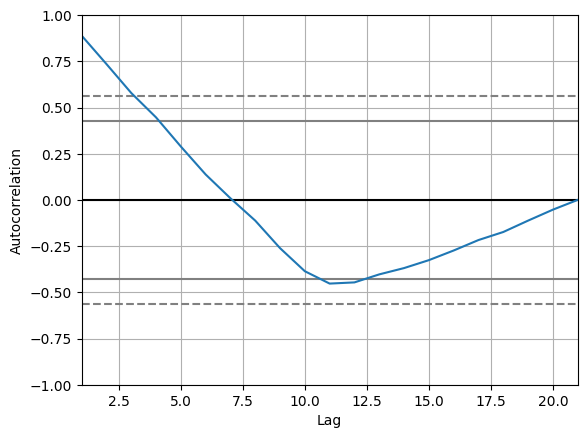

In [25]:
# Creating Autocorrelation plot - ACF
x = pd.plotting.autocorrelation_plot(data_filt['rev'])
x.plot()
plt.show()

The monotony of ACF is changed first time there is the p value. 

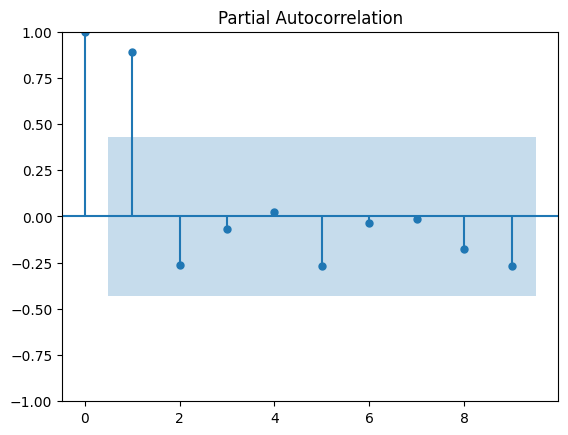

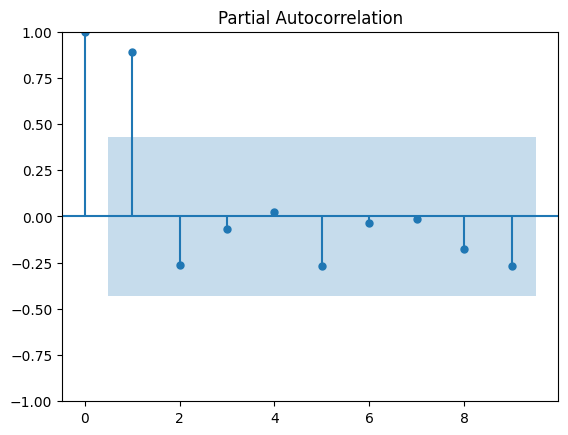

In [26]:
# Creating Partial Autocorrelation plot --> PACF
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data_filt['rev'], lags = int(forecast_period / 2 - 1))

Number of points, which are far away from the boundary is the q value.

In the above partial autocorrelation plot, we can see that only two points are far away from all the points. That is how a decide the q value. Hence the value of q is 2.

The value of d is either 0 or 1. If the data is stationary, we should use 0, and if the data is seasonal, we should use 1. As our data is seasonal, we should use 1 as the d value.

I will find ARIMA hyperparameters (p, d, q) with gridsearch step-by-step

In [27]:
# evaluate an ARIMA model for a given order (p,d,q) ---> You can tip p and estimate d, q based on previous plots
series = data_filt['rev']
# evaluate parameters
p_values = [2, 4]
d_values = [1]
q_values = [1, 3]
warnings.filterwarnings("ignore")
best_config = evaluate_models(series.values, p_values, d_values, q_values)

1.6235120069438456e+16
ARIMA(2, 1, 1) MSE=16235120069438456.000
2.7613169777765626e+17
ARIMA(2, 1, 3) MSE=276131697777656256.000
1.4097286052854932e+16
ARIMA(4, 1, 1) MSE=14097286052854932.000
2.237891429971036e+16
ARIMA(4, 1, 3) MSE=22378914299710360.000
Best ARIMA(4, 1, 1) MSE=14097286052854932.000


The predicted values are wrong because the data is seasonal. ARIMA model will never perform well on seasonal time series data. So, here’s how to build a SARIMA model.

The parameter "s" is an integer giving the periodicity (number of periods in season), often it is 4 for quarterly data or 12 for monthly data. Default is no seasonal effect. Here is hardcoded, works well with 12.

In [28]:
# float datatype is needed to SARIMAX model
data_filt['rev'] = data_filt['rev'].astype(float)

In [29]:
# use the model parameters of SARIMA
p, d, q = best_config
model=sm.tsa.statespace.SARIMAX(data_filt['rev'].values,
                                order=(p, d, q),
                                seasonal_order=(p, d, q, 12))
model=model.fit()
print(model.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03070D+25    |proj g|=  2.19879D+30


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11      2     47      2     0     0   8.865D+22   1.816D+20
  F =   1.8162705872778097E+020

ABNORMAL_TERMINATION_IN_LNSRCH                              
                                          SARIMAX Results                                          
Dep. Variable:                                  y   No. Observations:                            21
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 12)   Log Likelihood      -3814168233283400237056.000
Date:                            Sat, 30 Sep 2023   AIC                  7628336466566800474112.000
Time:                  


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


In [30]:
# use SARIMAX model
prediction_revenue = model.predict(len(data_filt), len(data_filt) + forecast_period)
# df from results
prediction = pd.DataFrame(
    prediction_revenue,
    index=[i+1 for i in range(len(prediction_revenue))],
    columns=['rev']
)

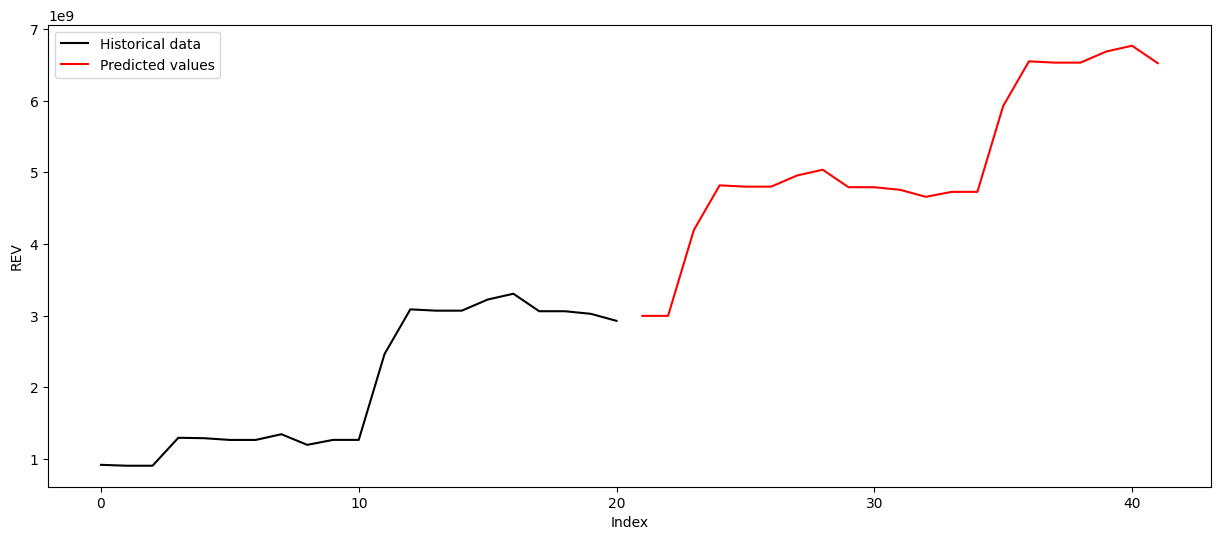

In [31]:
plot_hist_pred(data_filt, prediction)

## 4. Calculate ratios

After the revenue prediction I calculate the expenses and use those to predict future CoS and EBITDA.

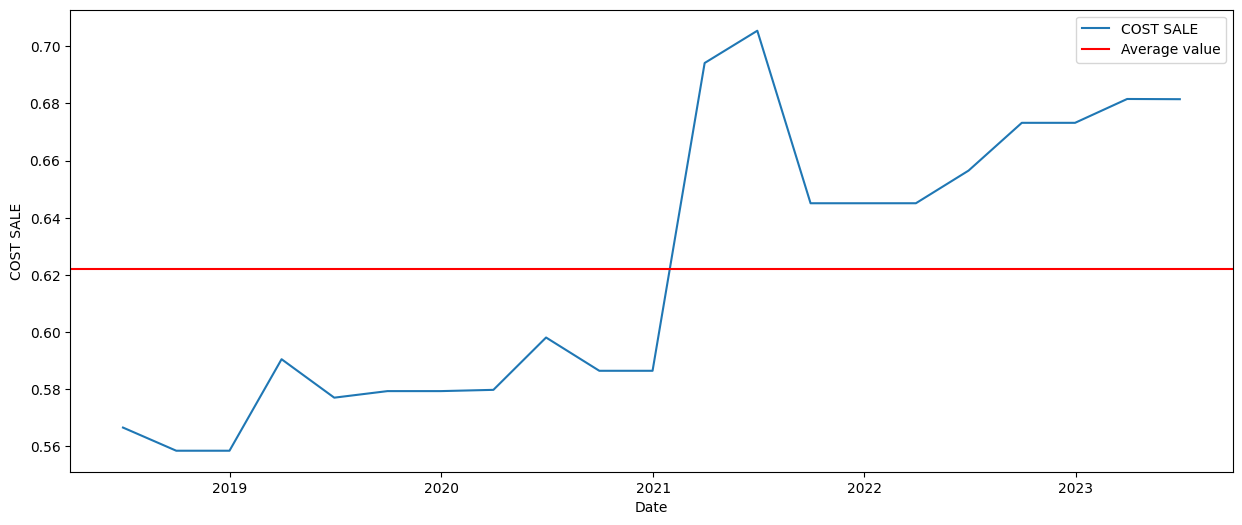

cost_sale is divided by the revenue.
Average value: 0.6219738216615369


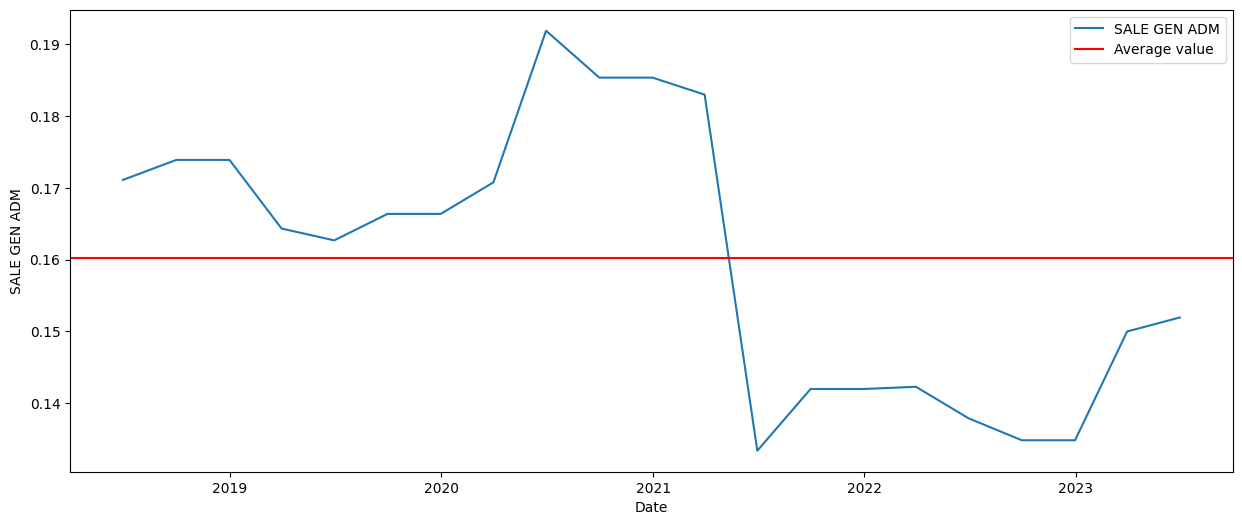

sale_gen_adm is divided by the revenue.
Average value: 0.16018290037465266


In [32]:
is_ratio_dictionary = calculate_is_margins(data_filt)

In [33]:
prediction = predict_cos_sale_gen_adm(prediction, is_ratio_dictionary)
prediction.tail()

,rev,cost_sale,sale_gen_adm
37,6.531455e+09,4.062394e+09,1.046227e+09
38,6.531455e+09,4.062394e+09,1.046227e+09
39,6.686454e+09,4.158800e+09,1.071056e+09
40,6.767455e+09,4.209180e+09,1.084031e+09
41,6.523455e+09,4.057418e+09,1.044946e+09


## 5. Calculate Fixed Assets

It's time to calculate D&A costs.

I will predict the PPE, D&A and CapEx values together.

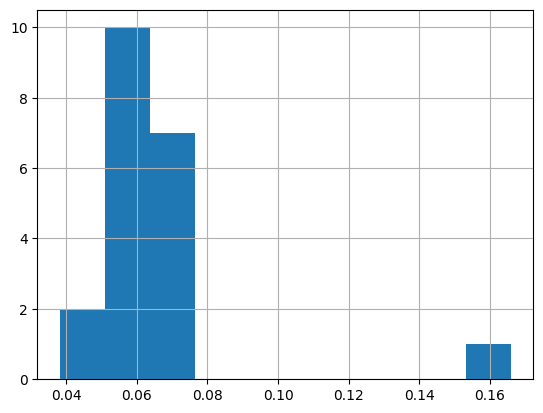

Average depr_amort value is 0.06568439609736336


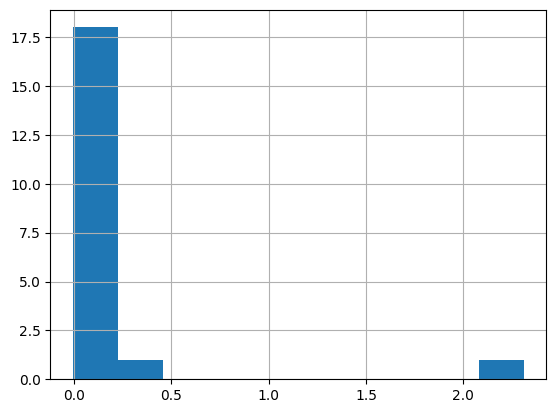

Average capex value is 0.19862492566274462


In [34]:
fxd_ass_ratios = fixed_asset_ratios(data_filt)

In [35]:
prediction = predict_fixed_assets(data_filt, prediction, fxd_ass_ratios)
prediction.head()

,rev,cost_sale,sale_gen_adm,depr_amort,capex,ppe_net
21,2.998227e+09,1.864819e+09,4.802648e+08,2.770568e+08,8.377999e+08,4.778743e+09
22,2.998227e+09,1.864819e+09,4.802648e+08,3.138889e+08,9.491775e+08,5.414032e+09
23,4.195227e+09,2.609322e+09,6.720037e+08,3.556174e+08,1.075362e+09,6.133776e+09
24,4.819227e+09,2.997433e+09,7.719578e+08,4.028934e+08,1.218321e+09,6.949203e+09
25,4.801227e+09,2.986238e+09,7.690745e+08,4.564542e+08,1.380285e+09,7.873034e+09


## 6. Calculate EBITDA, EBIT, NOPAT

In [36]:
eff_tax_rate = calc_eff_tax_rate(data_filt)

Effective tax rate is 0.21


In [37]:
prediction = calculate_ebitda_ebit_nopat(prediction, eff_tax_rate)
prediction.head()

,rev,cost_sale,sale_gen_adm,depr_amort,capex,ppe_net,ebitda,ebit,nopat
21,2.998227e+09,1.864819e+09,4.802648e+08,2.770568e+08,8.377999e+08,4.778743e+09,6.531437e+08,3.760869e+08,2.971086e+08
22,2.998227e+09,1.864819e+09,4.802648e+08,3.138889e+08,9.491775e+08,5.414032e+09,6.531437e+08,3.392548e+08,2.680113e+08
23,4.195227e+09,2.609322e+09,6.720037e+08,3.556174e+08,1.075362e+09,6.133776e+09,9.139021e+08,5.582847e+08,4.410449e+08
24,4.819227e+09,2.997433e+09,7.719578e+08,4.028934e+08,1.218321e+09,6.949203e+09,1.049836e+09,6.469429e+08,5.110849e+08
25,4.801227e+09,2.986238e+09,7.690745e+08,4.564542e+08,1.380285e+09,7.873034e+09,1.045915e+09,5.894609e+08,4.656741e+08


## 7. Function to plot Prediction vs Historical data

See at the functions...

## 8. Calculate Net Working Capital

To get this we have to forecast the current assets and liabilities.
I will use ratios to predict them:
- Days Sales Outstanding (dso) --> (Account recivable / Revenue) * 360
- Days Inventory Outstanding (dio) --> (Inventory / Cost of General Sale) * 360
- Other current assets per revenue (oca_rev) --> Other current assets / revenue
- Current liabilities per revenue (tcl_rec) --> (Total current liabilities - current debt) / revenue

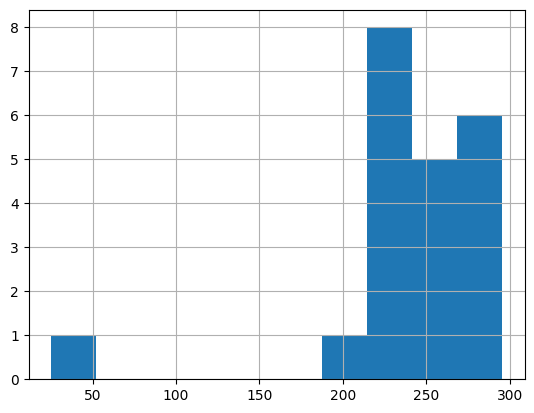

DSO: 243.83044427851678


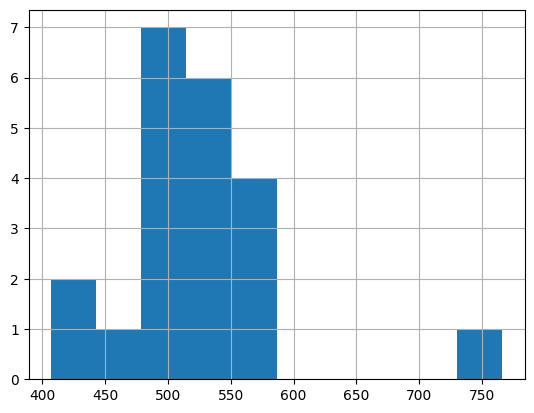

DIO: 527.1450630223858


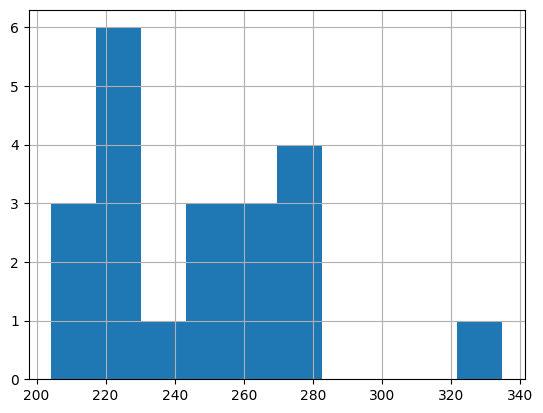

DPO: 247.42565932199523


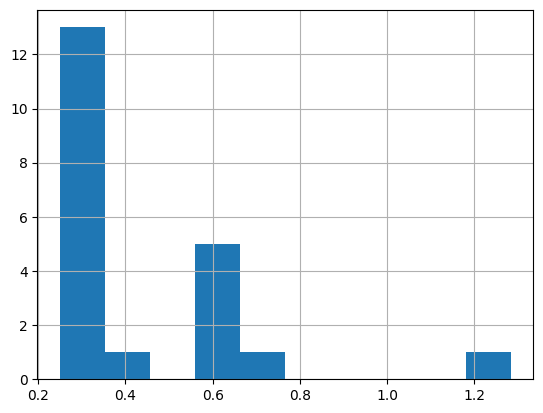

Sum Other Current Assets: 0.43253489206352264


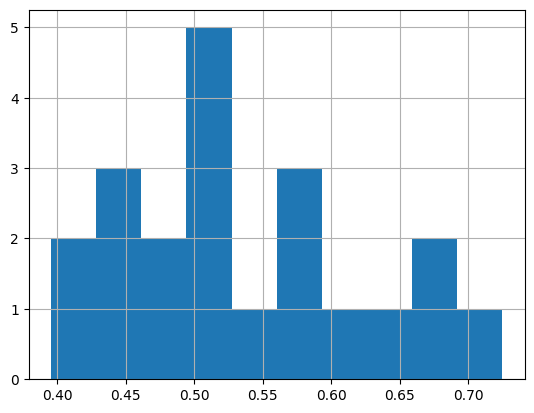

Sum Other Current Liabilities per Rec 0.5348013051842754


In [38]:
nwc_ratios = calculate_nwc_ratios(data_filt)

In [39]:
prediction = predict_curr_ass_liab(prediction, nwc_ratios)
prediction.head()

,rev,cost_sale,sale_gen_adm,depr_amort,capex,ppe_net,ebitda,ebit,nopat,acc_rec,invent,acc_pay,other_curr_ass_lesscash,tot_curr_liab_lessdebt,nwc
21,2.998227e+09,1.864819e+09,4.802648e+08,2.770568e+08,8.377999e+08,4.778743e+09,6.531437e+08,3.760869e+08,2.971086e+08,2.030720e+09,2.730639e+09,1.281678e+09,6.058197e+09,2.885134e+09,3.173063e+09
22,2.998227e+09,1.864819e+09,4.802648e+08,3.138889e+08,9.491775e+08,5.414032e+09,6.531437e+08,3.392548e+08,2.680113e+08,2.030720e+09,2.730639e+09,1.281678e+09,6.058197e+09,2.885134e+09,3.173063e+09
23,4.195227e+09,2.609322e+09,6.720037e+08,3.556174e+08,1.075362e+09,6.133776e+09,9.139021e+08,5.582847e+08,4.410449e+08,2.841456e+09,3.820808e+09,1.793370e+09,8.476846e+09,4.036983e+09,4.439864e+09
24,4.819227e+09,2.997433e+09,7.719578e+08,4.028934e+08,1.218321e+09,6.949203e+09,1.049836e+09,6.469429e+08,5.110849e+08,3.264095e+09,4.389117e+09,2.060116e+09,9.737696e+09,4.637445e+09,5.100251e+09
25,4.801227e+09,2.986238e+09,7.690745e+08,4.564542e+08,1.380285e+09,7.873034e+09,1.045915e+09,5.894609e+08,4.656741e+08,3.251904e+09,4.372724e+09,2.052422e+09,9.701326e+09,4.620124e+09,5.081201e+09


## 9. Change in NWC

In [40]:
prediction = calc_change_nwc(data_filt, prediction)
data_filt = calc_change_nwc(data_filt, data_filt)

In [41]:
prediction = calc_unleveared_fcf(prediction)
data_filt = calc_unleveared_fcf(data_filt)

## 10. Calculate Weighted Average Cost of Capital (WACC)

In [42]:
wacc = calculate_wacc(
    df=data_filt,
    share_price=share_price,
    eff_tax_rate=eff_tax_rate,
    us_bond_10_yr=us_bond_10_yr,
    equity_risk_premium=equity_risk_premium,
    beta=beta)

print('Estimated WACC value:', wacc)

Estimated WACC value: 0.06937930164678752


## 11. Present value of FCF, Terminal Value & present value of TV

In [43]:
prediction = calculate_present_value_fcf(prediction, wacc=wacc, report=form)
prediction.tail()

,rev,cost_sale,sale_gen_adm,depr_amort,capex,ppe_net,ebitda,ebit,nopat,acc_rec,invent,acc_pay,other_curr_ass_lesscash,tot_curr_liab_lessdebt,nwc,c_nwc,unlev_fcf,pres_val_fcf
37,6.531455e+09,4.062394e+09,1.046227e+09,2.041186e+09,6.172401e+09,3.520688e+10,1.422834e+09,-6.183526e+08,-4.884986e+08,4.423799e+09,5.948530e+09,2.792057e+09,1.319741e+10,6.285087e+09,6.912323e+09,-1.904965e+07,-4.600664e+09,-2.473726e+09
38,6.531455e+09,4.062394e+09,1.046227e+09,2.312542e+09,6.992963e+09,3.988730e+10,1.422834e+09,-8.897088e+08,-7.028700e+08,4.423799e+09,5.948531e+09,2.792057e+09,1.319741e+10,6.285088e+09,6.912324e+09,5.955682e+02,-5.383291e+09,-2.846401e+09
39,6.686454e+09,4.158800e+09,1.071056e+09,2.619973e+09,7.922612e+09,4.518994e+10,1.456599e+09,-1.163374e+09,-9.190654e+08,4.528781e+09,6.089696e+09,2.858316e+09,1.351060e+10,6.434241e+09,7.076362e+09,1.640377e+08,-6.385742e+09,-3.320294e+09
40,6.767455e+09,4.209180e+09,1.084031e+09,2.968274e+09,8.975848e+09,5.119751e+10,1.474245e+09,-1.494029e+09,-1.180283e+09,4.583643e+09,6.163468e+09,2.892942e+09,1.367427e+10,6.512186e+09,7.162086e+09,8.572413e+07,-7.273581e+09,-3.719037e+09
41,6.523455e+09,4.057418e+09,1.044946e+09,3.362878e+09,1.016910e+10,5.800373e+10,1.421091e+09,-1.941787e+09,-1.534012e+09,4.418380e+09,5.941244e+09,2.788637e+09,1.318125e+10,6.277389e+09,6.903857e+09,-2.582289e+08,-8.082007e+09,-4.063671e+09


## 12. Terminal Value and present value of TV

I use the perpetuity growth model

In [44]:
tv, pres_value_tv = calculate_tv_prestv_enterp_val(prediction, industry_growth_rate, wacc)
pres_value_tv

-156090066884.24817

In [45]:
enterp_val, equity_value = calc_enterp_company_value(data_filt, prediction, pres_value_tv)

-189319450655.39398 -199092450655.39398


In [46]:
# adjusted with debt, cash, equity in minor interest
fcst_share_price_adjusted = implied_share_price(equity_value, data_filt)
print('Current adjusted share price:', fcst_share_price_adjusted)

Current adjusted share price: -780.7547084525254


In [47]:
fcst_share_price = implied_share_price(enterp_val, data_filt)
print('Current share price (not adjusted):', fcst_share_price)

Current share price (not adjusted): -742.429218256447


In [48]:
#plot_hist_pred(data_filt, prediction)